# Chapter 12 과학적 계산

## 12.1 유한차분법 Finite Difference
- 많은 식들에 대해 공식이 없으며, 실제 해를 구할 수 없기에 한계가 있다. 따라서 주어진 미분방정식을 근사식 형태로 푸는 방법인 수치해석 Numerical analysis 가 매우 중요한 분야 중 하나이며, 이 수치해석 방법 중 하나를 말한다.
- 영역 내 시간에 따른 이미지의 패턴이 어떤지 알고 싶은 것인데, 유한차분법의 특징은 각 점의 변화를 계산할 때 주변 값을 이용한다는 것이다. 즉, 합성곱 신경망의 필터 계산과 같은 방법을 취하기 때문에 합성곱 연산을 이용하여 구현할 수 있다.

In [1]:
# 라이브러리 불러오기

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
# 초깃값 설정하기

def initial_value(nx, ny): # 이미지 사이즈 nx, ny
  h = 1 / nx
  x = np.linspace(-0.5 * h, h * (nx + 0.5), nx) # 이미지의 x,y 격자 수 정의
  y = np.linspace(-0.5 * h, h * (ny + 0.5), ny)
  pn = 0.5 * (2 * np.random.rand(nx,ny) - 1)
  # 초기 이미지 출력
  plt.figure(figsize=(4,4))
  plt.imshow(pn,interpolation='nearest',cmap='jet',extent=[x.min(),x.max(),y.min(),y.max()], origin='lower', aspect='auto')
  plt.title('$u(x,y,t=0)$',fontsize=20)
  plt.clim(-1,1)
  plt.show()
  return x, y, pn

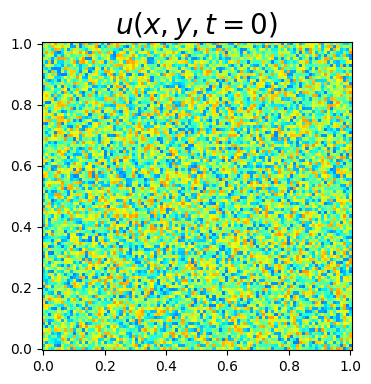

In [3]:
nx = ny = 100 # 이미지 사이즈
h = 1/nx
h2 = h**2
dt = .1*h**2
eps = 10*h/(2 * np.sqrt(2) * np.arctanh(0.9))
maxiter = 301 # 최대 타임 스텝
maxtime = dt * maxiter # 실제 마지막 시간
x, y, pn = initial_value(nx,ny) # 초기 이미지 생성

In [4]:
# 유한차분법 구현하기

class FDM(nn.Module):
  def __init__(self,h2,dt,eps,device):
    super(FDM,self).__init__()
    # 라플라스 연산인 2차 미분 필터를 구현함. 이때 F.conv2d의 필터는 3차원으로 만들어야 함
    self.delta = torch.Tensor([[[[0.,1.,0.],[1.,-4.,1],[0.,1.,0.]]]]).to(device)
    self.pad = nn.ReplicationPad2d(1) # 경계와 같은 값. 1겹 패딩
    self.alpha = dt/eps**2
    self.beta = dt/h2

  def forward(self,x):
    u_pad = self.pad(x) # 경계조건을 고려하기 위해 패딩 씌움
    diffusion = F.conv2d(u_pad,self.delta)  # 합성곱 연산을 미리 정의된 self.delta 필터를 사용하고 입력값은 u_pad
    x = (1+self.alpha)*x-self.alpha*x**3+self.beta*diffusion
    return x  # 타임 스텝

In [5]:
# 유한 차분법 클래스 선언하기

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = FDM(h2, dt, eps, device).to(device)
img = torch.FloatTensor(pn).view(-1,1,nx,ny).to(device) # 초기 이미지를 모델에 넣기 위해 4차원 텐서 변환

In [6]:
# 유한 차분법 시행하기

solutions = [] # 모든 타입 스텝을 저장할 수 있는 리스트 만듦
with torch.no_grad():
  for step in range(maxiter):
    u = model(img)
    # 이전 스텝의 이미지를 이용하여 다음 스텝의 이미지를 구함
    img = u # phi^(n+1) <- f(phi^n)
    solutions.append(img.view(nx,ny).cpu().numpy()) # 모든 결과 이미지를 넘파이 배열로 저장

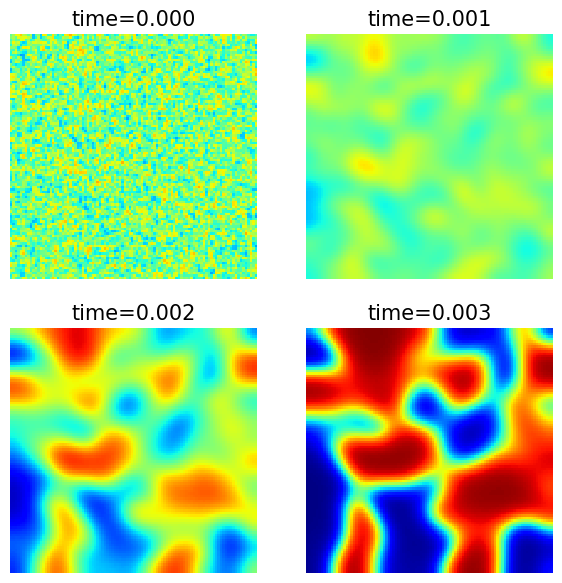

In [7]:
# 결과 확인하기

fig = plt.figure(figsize=(7,7))
d = range(221,225) # 2행2열 형태의 그래프를 그릴 수 있도록 값을 지정
timeslot = np.linspace(0,len(solutions)-1,4) # 0초부터 마지막까지 4등분한 시간을 계산
for i, subp in enumerate(d): # 부분 그래프를 하나씩 만들어 전체를 출력
  plt.subplot(subp)
  plt.imshow(solutions[int(timeslot[i])], interpolation = 'nearest', cmap = 'jet', extent=[x.min(), x.max(), y.min(), y.max()], origin='lower', aspect='auto')
  plt.clim(-1,1)
  plt.axis('off')
  plt.title('time=%.3f' %(dt*timeslot[i]),fontsize=15)
plt.show()

위는 반응 확산 방정식 중 하나인 Allen-Cahn 방정식을 무자구이 값으로 시작하여 0.003초간 현상을 시뮬레이션한 결과.